# Sparkles - Lab testing

In [2]:
from astropy.io import fits
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tempfile
import imageio
from scipy import signal
import sparkles as spkl
from importlib import reload
from scipy.optimize import curve_fit

sky_file_path = '../data/shortcut2/'
lab_file_path = '../data/eden_lab_sparkles_000/camwfs/'
# calibration files
calib_path = '../data/calib/'
mask = 'aol1_wfsmask.fits'
ref = 'aol1_wfsref.fits'
dark = 'camwfs-dark_bin2_2000.000000_600.000000_-45.000000__T20220422005142597501326.fits'

In [3]:
# Retrieve file lists
sky_f_list = spkl.return_files(sky_file_path)
lab_f_list = spkl.return_files(lab_file_path)

In [12]:
# sample both on sky and lab 
n=20000

s_data_cube, s_start, s_frame_list, s_wrt_list = spkl.file_sample(n, sky_f_list, sky_file_path)
l_data_cube, l_start, l_frame_list, l_wrt_list = spkl.file_sample(n, lab_f_list, lab_file_path)

In [13]:
# check continuous
print("Sky: start n = ", s_start, ', Continuous? ', spkl.check_cont(s_frame_list, s_wrt_list))
print("Lab: start n = ", l_start, ', Continuous? ', spkl.check_cont(l_frame_list, l_wrt_list))

Sky: start n =  1070832 , Continuous?  True
Lab: start n =  36002 , Continuous?  True


In [14]:
# clean and split both sky and lab
reload(spkl)

# cleaning
s_mat_ref_sub, dark_mat, mask_mat, ref_mat, ref_normed = spkl.clean_data_cube(s_data_cube, calib_path, dark, mask, ref)
l_mat_ref_sub, _, _, _, _ = spkl.clean_data_cube(l_data_cube, calib_path, dark, mask, ref)

# splitting
s_arr_clean = spkl.split_data_sub(s_mat_ref_sub)
l_arr_clean = spkl.split_data_sub(l_mat_ref_sub)

In [15]:
# NAN matrix for fun other things
mask_nan = mask_mat.copy()
mask_nan[mask_nan == 0] = np.nan
mask_nan_0 = mask_nan[0,:,:]

## Displaying split

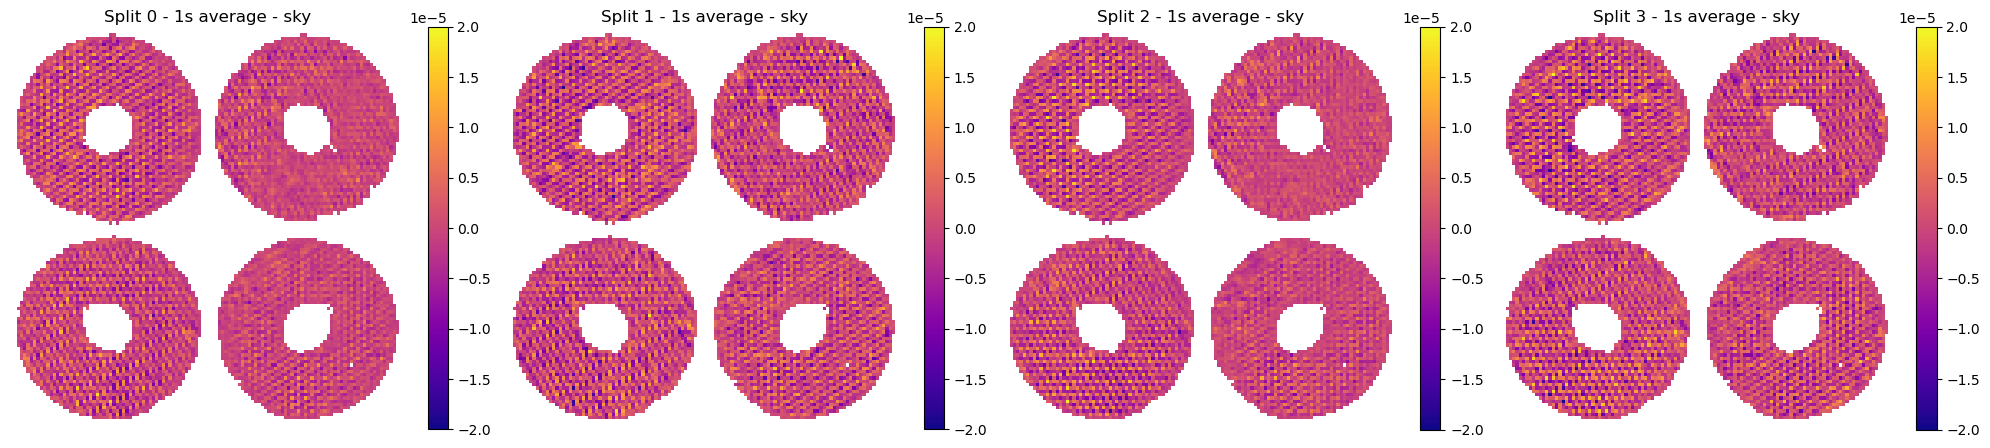

In [16]:
# display averages - sky
fig = plt.figure(figsize=(20,6), facecolor='white')

vmin = -2e-5
vmax = 2e-5

for i in range(4):
    ax = plt.subplot(141+i)
    plt.title(f'Split {i} - 1s average - sky')
    im = plt.imshow(np.nanmean(s_arr_clean[i], axis=0)*mask_nan_0, cmap = 'plasma', vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046)
    plt.axis('off')
plt.tight_layout()
plt.show()

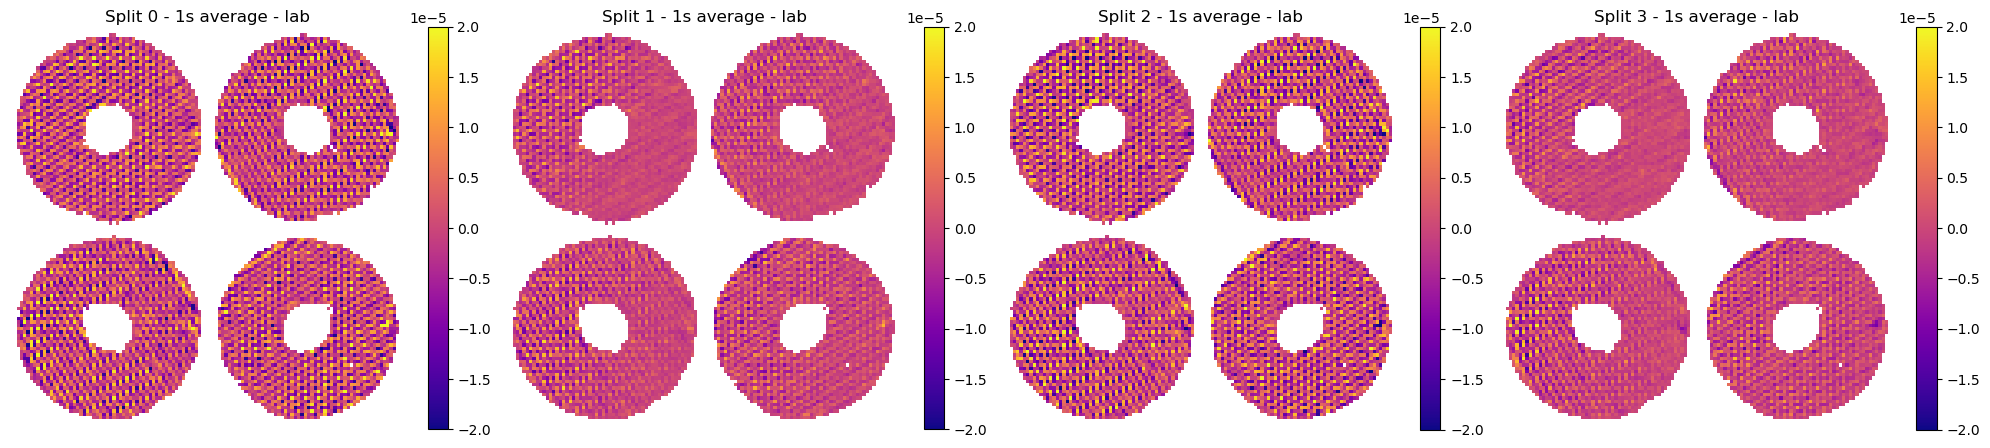

In [17]:
# display averages - lab
fig = plt.figure(figsize=(20,6), facecolor='white')

vmin = -2e-5
vmax = 2e-5

for i in range(4):
    ax = plt.subplot(141+i)
    plt.title(f'Split {i} - 1s average - lab')
    im = plt.imshow(np.nanmean(l_arr_clean[i], axis=0)*mask_nan_0, cmap = 'plasma', vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Measuring modal amplitudes

In [9]:
# dot product of the average with each individual frame
reload(spkl)
n_roll = 100

# lab data: dot product with own data
l_dot_mat = spkl.return_dot_mat(l_arr_clean, l_arr_clean)
l_dot_avgs, l_dot_stds = spkl.return_rolling(l_dot_mat, n=n_roll)

# sky data: dot product with lab data, see how it compares
s_dot_mat = spkl.return_dot_mat(s_arr_clean, s_arr_clean)
s_dot_avgs, s_dot_stds = spkl.return_rolling(s_dot_mat, n=n_roll)


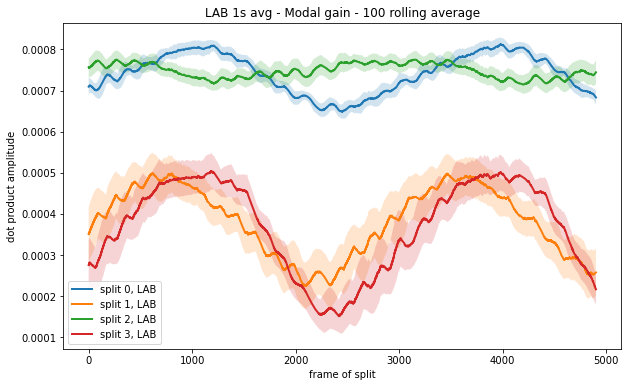

In [11]:
# Displaying lab splits - modal projections
fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(l_dot_avgs):
    plt.plot(l_dot_avgs[e], lw=2, label = f'split {e}, LAB')
    plt.fill_between(np.arange(len(l_dot_avgs[e])), l_dot_avgs[e]-l_dot_stds[e], l_dot_avgs[e]+l_dot_stds[e], alpha=0.2)

plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title("LAB 1s avg - Modal gain - 100 rolling average")
plt.show()

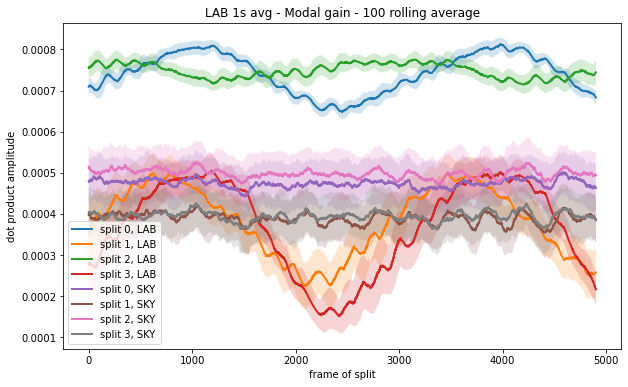

In [13]:
# compare lab with onsky datasets

fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(l_dot_avgs):
    plt.plot(l_dot_avgs[e], lw=2, label = f'split {e}, LAB')
    plt.fill_between(np.arange(len(l_dot_avgs[e])), l_dot_avgs[e]-l_dot_stds[e], l_dot_avgs[e]+l_dot_stds[e], alpha=0.2)

for e, mat in enumerate(s_dot_avgs):
    plt.plot(s_dot_avgs[e], lw=2, label = f'split {e}, SKY')
    plt.fill_between(np.arange(len(s_dot_avgs[e])), s_dot_avgs[e]-s_dot_stds[e], s_dot_avgs[e]+s_dot_stds[e], alpha=0.2)

plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title("LAB 1s avg - Modal gain - 100 rolling average")
plt.show()

### Cross split comparison: Rolling to match the modes better

In [14]:
# sky data: dot product with lab data, see how it compares
c_dot_mat = spkl.return_dot_mat(s_arr_clean, np.roll(l_arr_clean, 3, axis=0))
c_dot_avgs, c_dot_stds = spkl.return_rolling(c_dot_mat, n=n_roll)

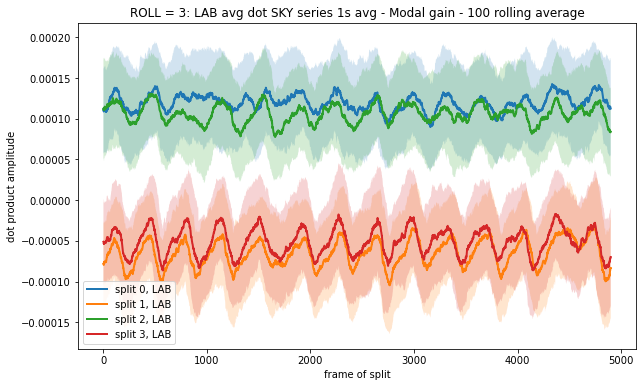

In [15]:
fig = plt.figure(figsize=(10,6), facecolor='white')
# need to roll to find which lab mode which on sky mode

# check for all references
    c_dot_avgs, c_dot_stds = spkl.return_rolling(c_dot_mat, n=n_roll)
    for e, mat in enumerate(c_dot_avgs):
        plt.plot(c_dot_avgs[e], lw=2, label = f'split {e}, LAB')
        plt.fill_between(np.arange(len(c_dot_avgs[e])), c_dot_avgs[e]-c_dot_stds[e], c_dot_avgs[e]+c_dot_stds[e], alpha=0.2)

plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title("ROLL = 3: LAB avg dot SKY series 1s avg - Modal gain - 100 rolling average")
plt.show()

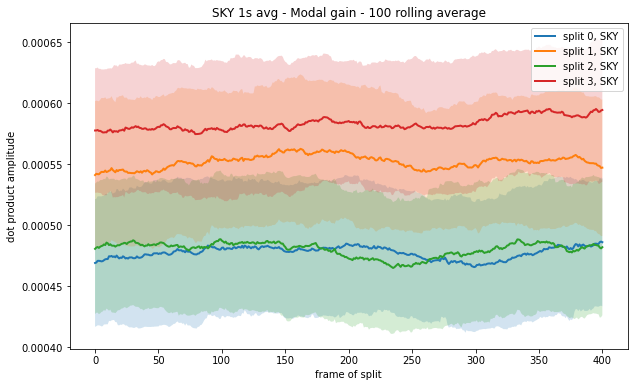

In [33]:
fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(s_dot_avgs):
    plt.plot(s_dot_avgs[e], lw=2, label = f'split {e}, SKY')
    plt.fill_between(np.arange(len(s_dot_avgs[e])), s_dot_avgs[e]-s_dot_stds[e], s_dot_avgs[e]+s_dot_stds[e], alpha=0.2)

plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title("SKY 1s avg - Modal gain - 100 rolling average")
plt.show()

## Lab Test - Loop closed

In [8]:
n=10000

In [4]:
#lc_file_path ='/home/eden/data/2022B/2022-09-27_28/_no_target_/spark_loopclosed_triggered_00/camwfs/'
lc_file_path ='/home/eden/data/2022B/spark_test_12_10/spark_sky_data/camwfs/'

# retrieve list of files
lc_f_list = spkl.return_files(lc_file_path)
print(len(lc_f_list))

41608


In [9]:
#retrieve data cube
lc_data_cube, lc_start, lc_frame_list, lc_wrt_list = spkl.file_sample(n, lc_f_list, lc_file_path)
#check data cube
print("Sky: start n = ", lc_start, ', Continuous? ', spkl.check_cont(lc_frame_list, lc_wrt_list))
#clean data cube
lc_mat_ref_sub, _, _, _, _ = spkl.clean_data_cube(lc_data_cube, calib_path, dark, mask, ref)
# splitting
lc_arr_clean = spkl.split_data_sub(lc_mat_ref_sub)

Sky: start n =  9309 , Continuous?  False


NameError: name 'mask_nan_0' is not defined

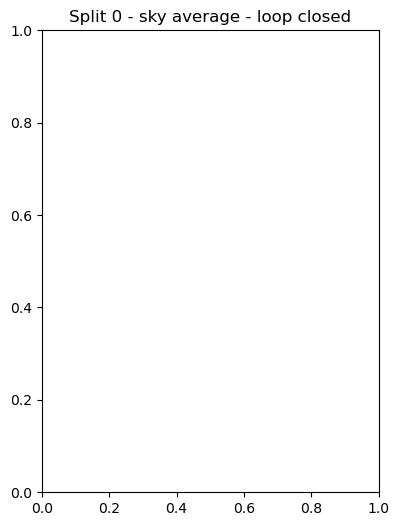

In [10]:
# display averages - lab
fig = plt.figure(figsize=(20,6), facecolor='white')

vmin = -2e-5
vmax = 2e-5

for i in range(4):
    ax = plt.subplot(141+i)
    #plt.title(f'Split {i} - n {n} average - lab loop closed')
    plt.title(f'Split {i} - sky average - loop closed')
    im = plt.imshow(np.nanmean(lc_arr_clean[i], axis=0)*mask_nan_0, cmap = 'plasma', vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# dot product of the average with each individual frame
n_roll = 100

# lab data: dot product with own data
lc_dot_mat = spkl.return_dot_mat(lc_arr_clean, lc_arr_clean)
lc_dot_avgs, lc_dot_stds = spkl.return_rolling(lc_dot_mat, n=n_roll)

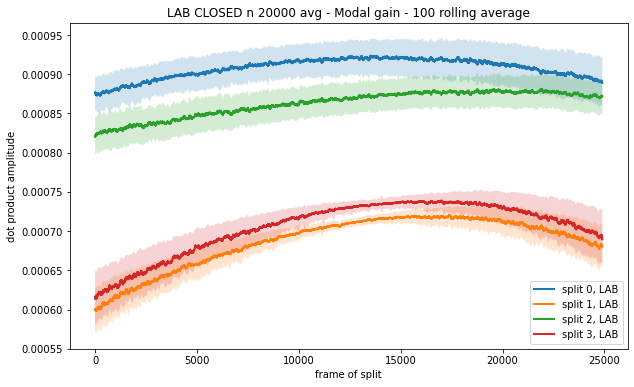

In [17]:
# Displaying lab splits - modal projections
fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(lc_dot_avgs):
    plt.plot(lc_dot_avgs[e], lw=2, label = f'split {e}, LAB')
    plt.fill_between(np.arange(len(lc_dot_avgs[e])), lc_dot_avgs[e]-lc_dot_stds[e], lc_dot_avgs[e]+lc_dot_stds[e], alpha=0.2)

plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title(f"LAB CLOSED n {n} avg - Modal gain - {n_roll} rolling average")
plt.show()

### Fitting curves

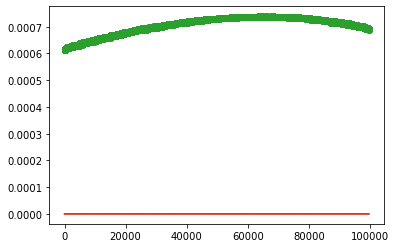

4.0522934906294175e-08 10000000.000005795


In [32]:
# we want to fit this curve:
ydata = (lc_dot_avgs[3])
xdata = np.arange(0, len(ydata)*4, 4)

def cos_func(x, D, E):
    y = D*np.cos(E*x)
    return y

guess = [0.001, 10e6]
parameters, covariance = curve_fit(cos_func, xdata, ydata, p0=guess)
fit_D = parameters[0]
fit_E = parameters[1]

fit_cosine = cos_func(xdata, fit_D, fit_E)

plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_cosine, '-', label='fit')
plt.savefig('03-cosine_fit2.png')


fit_cosine = cos_func(xdata, fit_D, fit_E)

plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_cosine, '-', label='fit')
plt.show()
print(fit_D, fit_E)


142


/opt/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


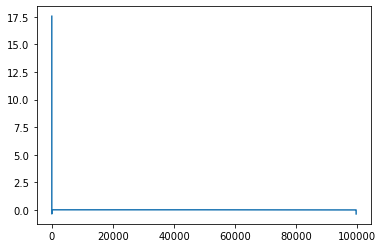

In [33]:
from scipy.fft import fft, ifft

x = ydata
y = fft(x)

plt.plot(xdata, y)
print(np.argmax(y[1:]))

## Lab Test - Loop open - no trigger

In [43]:
lo_file_path =  "/home/eden/data/2022B/2022-09-27_28/_no_target_/spark_loopopen_nottrigg_00/camwfs/"
# retrieve list of files
lo_f_list = spkl.return_files(lo_file_path)
print(len(lo_f_list))

143626


In [44]:
#retrieve data cube
lo_data_cube, lo_start, lo_frame_list, lo_wrt_list = spkl.file_sample(n, lo_f_list, lo_file_path)
#check data cube
print("Sky: start n = ", lo_start, ', Continuous? ', spkl.check_cont(lo_frame_list, lo_wrt_list))
#clean data cube
lo_mat_ref_sub, _, _, _, _ = spkl.clean_data_cube(lo_data_cube, calib_path, dark, mask, ref)
# splitting
lo_arr_clean = spkl.split_data_sub(lo_mat_ref_sub)

Sky: start n =  41394 , Continuous?  True


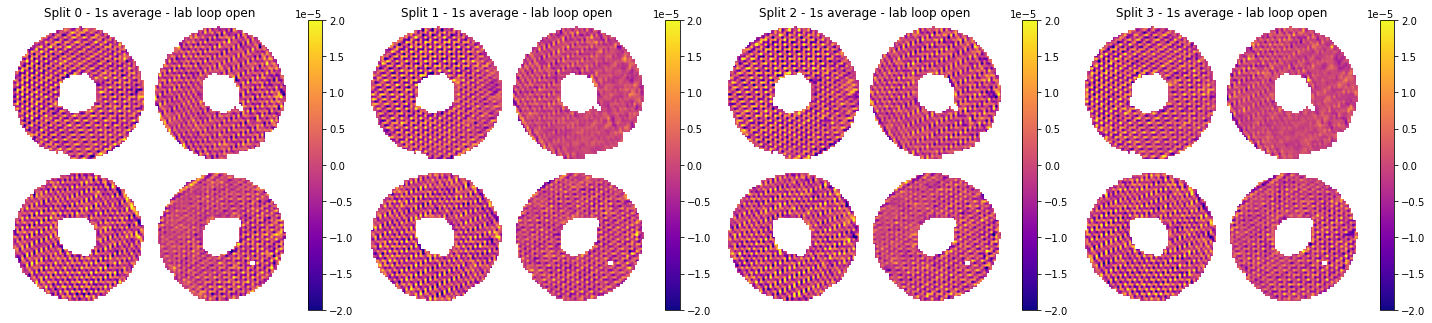

In [31]:
# display averages - lab
fig = plt.figure(figsize=(20,6), facecolor='white')

vmin = -2e-5
vmax = 2e-5

for i in range(4):
    ax = plt.subplot(141+i)
    plt.title(f'Split {i} - 1s average - lab loop open')
    im = plt.imshow(np.nanmean(lo_arr_clean[i], axis=0)*mask_nan_0, cmap = 'plasma', vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [33]:
# dot product of the average with each individual frame
n_roll = 100

# lab data: dot product with own data
lo_dot_mat = spkl.return_dot_mat(lo_arr_clean, lo_arr_clean)
lo_dot_avgs, lo_dot_stds = spkl.return_rolling(lo_dot_mat, n=n_roll)

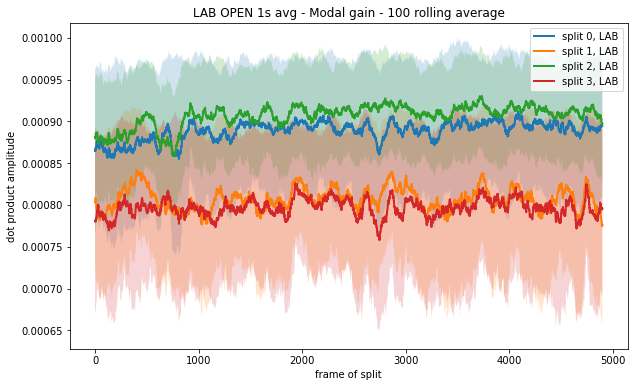

In [34]:
# Displaying lab splits - modal projections
fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(lo_dot_avgs):
    plt.plot(lo_dot_avgs[e], lw=2, label = f'split {e}, LAB')
    plt.fill_between(np.arange(len(lo_dot_avgs[e])), lo_dot_avgs[e]-lo_dot_stds[e], lo_dot_avgs[e]+lo_dot_stds[e], alpha=0.2)

plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title("LAB OPEN 1s avg - Modal gain - 100 rolling average")
plt.show()

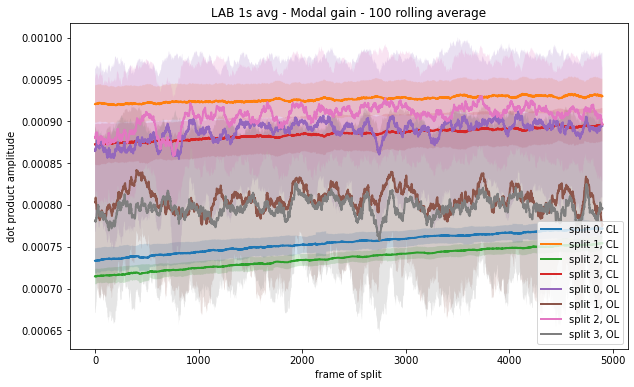

In [35]:
# compare open and closed

fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(l_dot_avgs):
    plt.plot(lc_dot_avgs[e], lw=2, label = f'split {e}, CL')
    plt.fill_between(np.arange(len(lc_dot_avgs[e])), lc_dot_avgs[e]-lc_dot_stds[e], lc_dot_avgs[e]+lc_dot_stds[e], alpha=0.2)

for e, mat in enumerate(lo_dot_avgs):
    plt.plot(lo_dot_avgs[e], lw=2, label = f'split {e}, OL')
    plt.fill_between(np.arange(len(lo_dot_avgs[e])), lo_dot_avgs[e]-lo_dot_stds[e], lo_dot_avgs[e]+lo_dot_stds[e], alpha=0.2)

plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title("LAB 1s avg - Modal gain - 100 rolling average")
plt.show()